### Kütüphaneleri yükle

In [1]:
import pandas as pd
import numpy as np
import pickle
import re
import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, multilabel_confusion_matrix, hamming_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# BERT için gerekli kütüphaneler
try:
    from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer
    from transformers import EarlyStoppingCallback, get_linear_schedule_with_warmup
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, TensorDataset, Dataset
    from torch.optim import AdamW
    BERT_AVAILABLE = True
    print("✓ BERT kütüphaneleri ve fine-tuning araçları yüklendi")
except ImportError:
    BERT_AVAILABLE = False
    print("⚠️ BERT kütüphaneleri bulunamadı. Sadece sklearn modelleri kullanılacak.")


✓ BERT kütüphaneleri ve fine-tuning araçları yüklendi


### Parametreleri ayarla

In [3]:
print("OneVsRestClassifier ile: Logistic Regression + SVM + Random Forest + BERT Fine-tuning\n")

# TF-IDF parametreleri
max_features = 50000
ngram_range = (1, 2)
min_df = 2
max_df = 0.95

OneVsRestClassifier ile: Logistic Regression + SVM + Random Forest + BERT Fine-tuning



In [4]:
# Model eğitim parametreleri
test_size = 0.2
random_state = 42

In [5]:
print(f"Vektörleştirme Parametreleri:")
print(f"- Max Features: {max_features}")
print(f"- N-gram Range: {ngram_range}")
print(f"- Min DF: {min_df}")
print(f"- Max DF: {max_df}")

Vektörleştirme Parametreleri:
- Max Features: 50000
- N-gram Range: (1, 2)
- Min DF: 2
- Max DF: 0.95


###  Metin ön işleme fonksiyonu

In [6]:
def text_preprocessing(text):
    """Metin ön işleme fonksiyonu - pickle edilebilir versiyon"""
    if pd.notna(text):
        # Küçük harfe çevir ve özel karakterleri temizle
        cleaned = re.sub(r'[^a-zA-Z0-9\s]', ' ', str(text).lower())
        # Fazla boşlukları temizle
        return ' '.join(cleaned.split())
    else:
        return ""

print("Metin ön işleme fonksiyonu hazırlandı.")

Metin ön işleme fonksiyonu hazırlandı.


### Gelişmiş Model Sınıfları

In [7]:
# Korelasyon-farkında kayıp fonksiyonu sınıfı
class CorrelationAwareLoss:
    """Korelasyon-farkında kayıp fonksiyonları"""
    
    @staticmethod
    def pairwise_ranking_loss(y_true, y_pred, margin=1.0):
        """Pairwise Ranking Loss - korelasyonlu etiketler için"""
        loss = 0.0
        n_samples, n_labels = y_true.shape
        
        for i in range(n_samples):
            # Pozitif ve negatif etiketleri ayır
            pos_indices = np.where(y_true[i] == 1)[0]
            neg_indices = np.where(y_true[i] == 0)[0]
            
            # Her pozitif-negatif çifti için ranking loss hesapla
            for pos_idx in pos_indices:
                for neg_idx in neg_indices:
                    # Pozitif etiketin skoru negatiften büyük olmalı
                    diff = y_pred[i, neg_idx] - y_pred[i, pos_idx] + margin
                    if diff > 0:
                        loss += diff
        
        return loss / n_samples if n_samples > 0 else 0.0
    
    @staticmethod
    def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
        """Focal Loss - dengesiz etiketler için"""
        epsilon = 1e-8
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        
        # Pozitif sınıflar için focal loss
        pos_loss = -alpha * (1 - y_pred) ** gamma * y_true * np.log(y_pred)
        
        # Negatif sınıflar için focal loss
        neg_loss = -(1 - alpha) * y_pred ** gamma * (1 - y_true) * np.log(1 - y_pred)
        
        return np.mean(pos_loss + neg_loss)

In [8]:
# Probabilistic Classifier Chain sınıfı
class ProbabilisticClassifierChain(BaseEstimator, ClassifierMixin):
    """Probabilistic Classifier Chain - belirsizlik modelleme ile"""
    
    def __init__(self, base_estimator, order=None, random_state=None):
        self.base_estimator = base_estimator
        self.order = order
        self.random_state = random_state
        
    def fit(self, X, Y):
        """Modeli eğit"""
        X, Y = check_X_y(X, Y, multi_output=True, accept_sparse=True)
        
        self.classes_ = []
        self.estimators_ = []
        self.n_labels_ = Y.shape[1]
        
        # Etiket sırasını belirle
        if self.order is None:
            # Korelasyon bazlı sıralama
            corr_matrix = np.corrcoef(Y.T)
            # En yüksek ortalama korelasyona sahip etiketleri önce al
            mean_corr = np.nanmean(np.abs(corr_matrix), axis=1)
            self.order_ = np.argsort(-mean_corr)
        else:
            self.order_ = self.order
            
        # Her etiket için bir estimator eğit
        for i, label_idx in enumerate(self.order_):
            y = Y[:, label_idx]
            self.classes_.append(unique_labels(y))
            
            # Önceki etiketlerin tahminlerini özellik olarak ekle
            if i == 0:
                X_extended = X
            else:
                # Önceki etiketlerin gerçek değerlerini kullan (eğitim sırasında)
                prev_labels = Y[:, self.order_[:i]]
                if hasattr(X, 'toarray'):
                    X_extended = np.hstack([X.toarray(), prev_labels])
                else:
                    X_extended = np.hstack([X, prev_labels])
            
            # Estimator'ı kopyala ve eğit
            estimator = pickle.loads(pickle.dumps(self.base_estimator))
            estimator.fit(X_extended, y)
            self.estimators_.append(estimator)
            
        return self
    
    def predict(self, X):
        """Tahmin yap"""
        check_is_fitted(self)
        X = check_array(X, accept_sparse=True)
        
        n_samples = X.shape[0]
        Y_pred = np.zeros((n_samples, self.n_labels_))
        
        # Sıralı tahmin
        for i, (label_idx, estimator) in enumerate(zip(self.order_, self.estimators_)):
            if i == 0:
                X_extended = X
            else:
                # Önceki tahminleri özellik olarak kullan
                prev_preds = Y_pred[:, self.order_[:i]]
                if hasattr(X, 'toarray'):
                    X_extended = np.hstack([X.toarray(), prev_preds])
                else:
                    X_extended = np.hstack([X, prev_preds])
            
            Y_pred[:, label_idx] = estimator.predict(X_extended)
            
        return Y_pred.astype(int)
    
    def predict_proba(self, X):
        """Olasılık tahminleri"""
        check_is_fitted(self)
        X = check_array(X, accept_sparse=True)
        
        n_samples = X.shape[0]
        Y_proba = np.zeros((n_samples, self.n_labels_))
        
        for i, (label_idx, estimator) in enumerate(zip(self.order_, self.estimators_)):
            if i == 0:
                X_extended = X
            else:
                # Monte Carlo sampling ile belirsizlik modelle
                prev_preds = Y_proba[:, self.order_[:i]]
                if hasattr(X, 'toarray'):
                    X_extended = np.hstack([X.toarray(), prev_preds])
                else:
                    X_extended = np.hstack([X, prev_preds])
            
            if hasattr(estimator, 'predict_proba'):
                proba = estimator.predict_proba(X_extended)
                if proba.shape[1] == 2:
                    Y_proba[:, label_idx] = proba[:, 1]
                else:
                    Y_proba[:, label_idx] = proba[:, 0]
            else:
                # Eğer predict_proba yoksa decision_function kullan
                if hasattr(estimator, 'decision_function'):
                    scores = estimator.decision_function(X_extended)
                    Y_proba[:, label_idx] = 1 / (1 + np.exp(-scores))  # Sigmoid
                else:
                    Y_proba[:, label_idx] = estimator.predict(X_extended)
                    
        return Y_proba

#### BERT Model Sınıfları ve Fine-tuning (eğer BERT kullanılabilirse)

In [9]:
 # Özel Dataset sınıfı
class MultiLabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }


In [10]:
# Gelişmiş BERT Multi-Label Classifier
class BERTMultiLabelClassifier(nn.Module):
    def __init__(self, model_name='distilbert-base-uncased', num_labels=49, dropout_rate=0.3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)
        # Çoklu katmanlı classifier
        hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size // 2, num_labels)
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # [CLS] token + mean pooling
        cls_output = outputs.last_hidden_state[:, 0]  # [CLS] token
        mean_output = torch.mean(outputs.last_hidden_state, dim=1)  # Mean pooling
        combined = (cls_output + mean_output) / 2  # Ortalama al
        
        output = self.dropout(combined)
        logits = self.classifier(output)
        return self.sigmoid(logits)

In [11]:
# Fine-tuning Trainer sınıfı
class BERTFineTuner:
    def __init__(self, model_name='distilbert-base-uncased', num_labels=49, device=None):
        self.model_name = model_name
        self.num_labels = num_labels
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None
        self.tokenizer = None
        
    def prepare_model(self):
        """Model ve tokenizer'ı hazırla"""
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = BERTMultiLabelClassifier(self.model_name, self.num_labels)
        self.model.to(self.device)
        
    def train(self, train_texts, train_labels, val_texts=None, val_labels=None, 
             epochs=3, batch_size=16, learning_rate=2e-5, warmup_steps=500):
        """Fine-tuning işlemi"""
        if self.model is None:
            self.prepare_model()
        
        # Dataset'leri hazırla
        train_dataset = MultiLabelDataset(train_texts, train_labels, self.tokenizer)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        if val_texts is not None and val_labels is not None:
            val_dataset = MultiLabelDataset(val_texts, val_labels, self.tokenizer)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        else:
            val_loader = None
        
        # Optimizer ve scheduler
        optimizer = AdamW(self.model.parameters(), lr=learning_rate)
        total_steps = len(train_loader) * epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
        )
        
        # Loss fonksiyonu (weighted binary cross entropy)
        criterion = nn.BCELoss()
        
        # Eğitim döngüsü
        best_val_loss = float('inf')
        patience = 2
        patience_counter = 0
        
        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs}")
            
            # Eğitim
            self.model.train()
            total_train_loss = 0
            
            for batch_idx, batch in enumerate(train_loader):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                
                total_train_loss += loss.item()
                
                if batch_idx % 50 == 0:
                    print(f"  Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
            
            avg_train_loss = total_train_loss / len(train_loader)
            print(f"  Ortalama eğitim kaybı: {avg_train_loss:.4f}")
            
            # Validation
            if val_loader:
                self.model.eval()
                total_val_loss = 0
                
                with torch.no_grad():
                    for batch in val_loader:
                        input_ids = batch['input_ids'].to(self.device)
                        attention_mask = batch['attention_mask'].to(self.device)
                        labels = batch['labels'].to(self.device)
                        
                        outputs = self.model(input_ids, attention_mask)
                        loss = criterion(outputs, labels)
                        total_val_loss += loss.item()
                
                avg_val_loss = total_val_loss / len(val_loader)
                print(f"  Validation kaybı: {avg_val_loss:.4f}")
                
                # Early stopping
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"  Early stopping! En iyi validation loss: {best_val_loss:.4f}")
                        break
        
        return self.model
    
    def predict(self, texts, batch_size=32):
        """Tahmin yap"""
        if self.model is None:
            raise ValueError("Model henüz eğitilmedi!")
        
        dataset = MultiLabelDataset(texts, [[0] * self.num_labels] * len(texts), self.tokenizer)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
        self.model.eval()
        predictions = []
        probabilities = []
        
        with torch.no_grad():
            for batch in loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                
                outputs = self.model(input_ids, attention_mask)
                probs = outputs.cpu().numpy()
                preds = (probs > 0.5).astype(int)
                
                predictions.extend(preds)
                probabilities.extend(probs)
        
        return np.array(predictions), np.array(probabilities)

In [12]:
# Korelasyon-farkında BERT Loss
class CorrelationAwareBERTLoss(nn.Module):
    def __init__(self, correlation_matrix, alpha=0.1):
        super().__init__()
        self.correlation_matrix = torch.tensor(correlation_matrix, dtype=torch.float32)
        self.alpha = alpha
        self.bce_loss = nn.BCELoss()
        
    def forward(self, predictions, targets):
        # Standart BCE loss
        bce = self.bce_loss(predictions, targets)
        
        # Korelasyon penalty
        corr_penalty = 0.0
        batch_size, n_labels = predictions.shape
        
        for i in range(n_labels):
            for j in range(i+1, n_labels):
                if abs(self.correlation_matrix[i, j]) > 0.3:  # Yüksek korelasyon
                    # Korelasyonlu etiketlerin tahminleri tutarlı olmalı
                    pred_diff = torch.abs(predictions[:, i] - predictions[:, j])
                    target_diff = torch.abs(targets[:, i] - targets[:, j])
                    corr_penalty += torch.mean(torch.abs(pred_diff - target_diff))
        
        return bce + self.alpha * corr_penalty

### Veri setini yükle ve hazırla

In [13]:
print("\nVeri seti yükleniyor...")
df = pd.read_csv('preprocessed_dataset_3.csv')
print(f"Orijinal veri seti boyutu: {df.shape}")


Veri seti yükleniyor...
Orijinal veri seti boyutu: (158804, 5)


In [14]:
# Text sütununu ön işle
print("Metin ön işleme yapılıyor...")
df['text'] = df['text'].apply(text_preprocessing)

Metin ön işleme yapılıyor...


In [15]:
# Boş metinleri filtrele
df = df[df['text'].str.len() > 0].reset_index(drop=True)

In [16]:
# Etiket sütunlarını belirle
label_columns = [col for col in df.columns if col != 'text']

In [17]:
print(f"Etiket sayısı: {len(label_columns)}")
print(f"Temizlenmiş veri boyutu: {df.shape}")

Etiket sayısı: 4
Temizlenmiş veri boyutu: (158804, 5)


In [18]:
# Veri boyutunu sınırla (BERT için)
if len(df) > 50000:
    print(f"Veri seti {len(df)} satır. BERT eğitimi için ilk 50000 satır kullanılacak.")
    df = df.head(50000).copy()


Veri seti 158804 satır. BERT eğitimi için ilk 50000 satır kullanılacak.


### Sınıf dağılımını analiz et

In [19]:
# Özellik ve etiketleri ayır
X = df['text']
y = df[label_columns]

In [20]:
label_sums = y.sum(axis=0)
min_samples = label_sums.min()
max_samples = label_sums.max()

In [21]:
print(f"En az örnek: {min_samples}")
print(f"En çok örnek: {max_samples}")
print(f"Dengesizlik oranı: {max_samples/min_samples:.2f}")

En az örnek: 11847
En çok örnek: 23289
Dengesizlik oranı: 1.97


In [22]:
# Dağılım DataFrame'i
distribution_df = pd.DataFrame({
    'label': label_columns,
    'count': label_sums,
    'percentage': (label_sums / len(y)) * 100
}).sort_values('count')

In [23]:
print("\nEn az örnekli 5 etiket:")
print(distribution_df.head())
print("\nEn çok örnekli 5 etiket:")
print(distribution_df.tail())


En az örnekli 5 etiket:
                                 label  count  percentage
Pazarlar & Ticaret  Pazarlar & Ticaret  11847      23.694
Hükümet & Sosyal      Hükümet & Sosyal  15906      31.812
Ekonomi & Finans      Ekonomi & Finans  18506      37.012
İş & Endüstri            İş & Endüstri  23289      46.578

En çok örnekli 5 etiket:
                                 label  count  percentage
Pazarlar & Ticaret  Pazarlar & Ticaret  11847      23.694
Hükümet & Sosyal      Hükümet & Sosyal  15906      31.812
Ekonomi & Finans      Ekonomi & Finans  18506      37.012
İş & Endüstri            İş & Endüstri  23289      46.578


### Korelasyon Analizi

In [24]:
# Etiketler arası korelasyon matrisini hesapla
correlation_matrix = y.corr()
print(f"Korelasyon matrisi boyutu: {correlation_matrix.shape}")

Korelasyon matrisi boyutu: (4, 4)


In [25]:
# Yüksek korelasyonlu etiket çiftlerini bul
high_corr_pairs = []
threshold = 0.3  # Korelasyon eşiği

In [26]:
for i in range(len(label_columns)):
    for j in range(i+1, len(label_columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > threshold:
            high_corr_pairs.append({
                'label1': label_columns[i],
                'label2': label_columns[j],
                'correlation': corr_val
            })

In [27]:
# Yüksek korelasyonlu çiftleri sırala
high_corr_pairs = sorted(high_corr_pairs, key=lambda x: abs(x['correlation']), reverse=True)


In [28]:
print(f"\nYüksek korelasyonlu etiket çiftleri (|r| > {threshold}):")
print(f"Toplam {len(high_corr_pairs)} çift bulundu")



Yüksek korelasyonlu etiket çiftleri (|r| > 0.3):
Toplam 5 çift bulundu


In [29]:
if high_corr_pairs:
    print("\nEn yüksek korelasyonlu 10 çift:")
    for i, pair in enumerate(high_corr_pairs[:10]):
        print(f"{i+1}. {pair['label1']} - {pair['label2']}: {pair['correlation']:.3f}")



En yüksek korelasyonlu 10 çift:
1. Ekonomi & Finans - Pazarlar & Ticaret: 0.725
2. Ekonomi & Finans - İş & Endüstri: -0.442
3. Hükümet & Sosyal - İş & Endüstri: -0.387
4. Pazarlar & Ticaret - İş & Endüstri: -0.373
5. Hükümet & Sosyal - Pazarlar & Ticaret: -0.343


In [30]:
# Ortalama korelasyon değerlerini hesapla
all_correlations = []
for i in range(len(label_columns)):
    for j in range(i+1, len(label_columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if not np.isnan(corr_val):
            all_correlations.append(abs(corr_val))

In [31]:
if all_correlations:
    mean_corr = np.mean(all_correlations)
    max_corr = np.max(all_correlations)
    print(f"\nOrtalama mutlak korelasyon: {mean_corr:.3f}")
    print(f"Maksimum mutlak korelasyon: {max_corr:.3f}")


Ortalama mutlak korelasyon: 0.428
Maksimum mutlak korelasyon: 0.725


In [32]:
# Korelasyon matrisini görselleştir (en çok kullanılan 15 etiket için)
if len(label_columns) > 15:
    top_labels = distribution_df.tail(15)['label'].tolist()
    corr_subset = y[top_labels].corr()
    
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_subset, dtype=bool))
    sns.heatmap(corr_subset, mask=mask, annot=True, cmap='coolwarm', 
                center=0, square=True, linewidths=0.5, 
                fmt='.2f', annot_kws={'size': 8})
    plt.title('En Çok Kullanılan 15 Etiket Arası Korelasyon Matrisi', fontsize=14)
    plt.tight_layout()
    plt.savefig('label_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Korelasyon matrisi 'label_correlations.png' olarak kaydedildi")

### Train-test split

In [33]:
print("\nVeri seti ayrılıyor...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, stratify=None
)


Veri seti ayrılıyor...


In [34]:
print(f"Eğitim seti boyutu: {len(X_train)}")
print(f"Test seti boyutu: {len(X_test)}")

Eğitim seti boyutu: 40000
Test seti boyutu: 10000


### TF-IDF vektörleştirme

In [35]:
# TF-IDF vektörleştirici
tfidf_vectorizer = TfidfVectorizer(
    max_features=max_features,
    ngram_range=ngram_range,
    min_df=min_df,
    max_df=max_df,
    stop_words='english',
    lowercase=True,
    strip_accents='ascii'
)

In [36]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [37]:
print(f"TF-IDF özellik boyutu: {X_train_tfidf.shape[1]}")

TF-IDF özellik boyutu: 50000


### Model 1: OneVsRestClassifier ile Logistic Regression

In [38]:
start_time = time.time()

lr_base_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=random_state,
    solver='liblinear'
)

In [39]:
lr_ovr_model = OneVsRestClassifier(lr_base_model, n_jobs=-1)
lr_ovr_model.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                 max_iter=1000, random_state=42,
                                                 solver='liblinear'),
                    n_jobs=-1)

In [40]:
lr_ovr_train_time = time.time() - start_time
print(f"OneVsRest Logistic Regression eğitim süresi: {lr_ovr_train_time:.2f} saniye")


OneVsRest Logistic Regression eğitim süresi: 5.74 saniye


In [41]:
# OneVsRest Logistic Regression tahminleri
print("OneVsRest Logistic Regression tahminleri yapılıyor...")
lr_ovr_pred = lr_ovr_model.predict(X_test_tfidf)

OneVsRest Logistic Regression tahminleri yapılıyor...


####  Model 1b: MultiOutputClassifier ile Logistic Regression (karşılaştırma için)

In [42]:
start_time = time.time()

lr_base_model_multi = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=random_state,
    solver='liblinear'
)

In [43]:

lr_multi_model = MultiOutputClassifier(lr_base_model_multi, n_jobs=-1)
lr_multi_model.fit(X_train_tfidf, y_train)

MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                   max_iter=1000,
                                                   random_state=42,
                                                   solver='liblinear'),
                      n_jobs=-1)

In [44]:
lr_multi_train_time = time.time() - start_time
print(f"MultiOutput Logistic Regression eğitim süresi: {lr_multi_train_time:.2f} saniye")


MultiOutput Logistic Regression eğitim süresi: 4.79 saniye


In [45]:
# MultiOutput Logistic Regression tahminleri
print("MultiOutput Logistic Regression tahminleri yapılıyor...")
lr_multi_pred = lr_multi_model.predict(X_test_tfidf)


MultiOutput Logistic Regression tahminleri yapılıyor...


###  Model 2: OneVsRestClassifier ile SVM

In [46]:
start_time = time.time()

svm_base_model = SVC(
    kernel='linear',
    class_weight='balanced', 
    probability=False,  # Olasılık hesaplaması yapılmayacak
    random_state=random_state,
    max_iter=500,
    cache_size=2000,  # Cache boyutunu artır
    shrinking=True  # Shrinking heuristiği aktif
)


In [47]:
# Paralelleştirme olmadan eğit (salt okunur hatası önlemek için)
svm_ovr_model = OneVsRestClassifier(svm_base_model, n_jobs=None)
svm_ovr_model.fit(X_train_tfidf, y_train)


OneVsRestClassifier(estimator=SVC(cache_size=2000, class_weight='balanced',
                                  kernel='linear', max_iter=500,
                                  random_state=42))

In [48]:
svm_ovr_train_time = time.time() - start_time
print(f"OneVsRest SVM eğitim süresi: {svm_ovr_train_time:.2f} saniye")

OneVsRest SVM eğitim süresi: 126.79 saniye


In [49]:
# OneVsRest SVM tahminleri
print("OneVsRest SVM tahminleri yapılıyor...")
svm_ovr_pred = svm_ovr_model.predict(X_test_tfidf)

OneVsRest SVM tahminleri yapılıyor...


In [ ]:
# OneVsRest SVM sonuçları
print("\n=== OneVsRest SVM Sonuçları ===")

# Genel performans metrikleri
accuracy = accuracy_score(y_test, svm_ovr_pred)
hamming = hamming_loss(y_test, svm_ovr_pred)

print(f"Subset Accuracy: {accuracy:.4f}")
print(f"Hamming Loss: {hamming:.4f}")


### Model 3: OneVsRestClassifier ile Random Forest

In [50]:
start_time = time.time()

rf_base_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    class_weight='balanced',
    random_state=random_state,
    n_jobs=-1
)

In [51]:
rf_ovr_model = OneVsRestClassifier(rf_base_model, n_jobs=-1)
rf_ovr_model.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                     max_depth=20, n_jobs=-1,
                                                     random_state=42),
                    n_jobs=-1)

In [52]:
rf_ovr_train_time = time.time() - start_time
print(f"OneVsRest Random Forest eğitim süresi: {rf_ovr_train_time:.2f} saniye")

OneVsRest Random Forest eğitim süresi: 19.12 saniye


In [53]:
# OneVsRest Random Forest tahminleri
print("OneVsRest Random Forest tahminleri yapılıyor...")
rf_ovr_pred = rf_ovr_model.predict(X_test_tfidf)

OneVsRest Random Forest tahminleri yapılıyor...


In [123]:
# OneVsRest Random Forest sonuçları
print("\n=== OneVsRest Random Forest Sonuçları ===")

# Genel performans metrikleri
accuracy = accuracy_score(y_test, rf_ovr_pred)
hamming = hamming_loss(y_test, rf_ovr_pred)

print(f"Subset Accuracy: {accuracy:.4f}")
print(f"Hamming Loss: {hamming:.4f}")




=== OneVsRest Random Forest Sonuçları ===
Subset Accuracy: 0.7827
Hamming Loss: 0.0757


####  Model 3b: MultiOutputClassifier ile Random Forest (karşılaştırma için)

In [54]:
start_time = time.time()

rf_base_model_multi = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    class_weight='balanced',
    random_state=random_state,
    n_jobs=-1
)

In [55]:
rf_multi_model = MultiOutputClassifier(rf_base_model_multi, n_jobs=-1)
rf_multi_model.fit(X_train_tfidf, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=20, n_jobs=-1,
                                                       random_state=42),
                      n_jobs=-1)

In [56]:
rf_multi_train_time = time.time() - start_time
print(f"MultiOutput Random Forest eğitim süresi: {rf_multi_train_time:.2f} saniye")


MultiOutput Random Forest eğitim süresi: 21.22 saniye


In [57]:
# MultiOutput Random Forest tahminleri
print("MultiOutput Random Forest tahminleri yapılıyor...")
rf_multi_pred = rf_multi_model.predict(X_test_tfidf)

MultiOutput Random Forest tahminleri yapılıyor...


In [ ]:
# MultiOutput Random Forest sonuçları
print("\n=== MultiOutput Random Forest Sonuçları ===")

# Genel performans metrikleri
accuracy = accuracy_score(y_test, rf_multi_pred)
hamming = hamming_loss(y_test, rf_multi_pred)

print(f"Subset Accuracy: {accuracy:.4f}")
print(f"Hamming Loss: {hamming:.4f}")

# Her sınıf için performans metrikleri
for i, label in enumerate(label_columns):
    try:
        y_true_col = safe_get_column(y_test, i, label)
        y_pred_col = safe_get_column(rf_multi_pred, i)
        
        accuracy = accuracy_score(y_true_col, y_pred_col)
        precision = precision_score(y_true_col, y_pred_col, zero_division=0)
        recall = recall_score(y_true_col, y_pred_col, zero_division=0)
        f1 = f1_score(y_true_col, y_pred_col, zero_division=0)
        
        # Pozitif ve negatif örnek sayıları
        pos_samples = int(np.sum(y_true_col))
        neg_samples = len(y_true_col) - pos_samples
        
        # Confusion matrix elemanları
        tp = int(np.sum((y_true_col == 1) & (y_pred_col == 1)))
        fp = int(np.sum((y_true_col == 0) & (y_pred_col == 1)))
        fn = int(np.sum((y_true_col == 1) & (y_pred_col == 0)))
        tn = int(np.sum((y_true_col == 0) & (y_pred_col == 0)))
        
        print(f"\n{label} sınıfı için:")
        print(f"Doğruluk (Accuracy): {accuracy:.4f}")
        print(f"Kesinlik (Precision): {precision:.4f}")
        print(f"Duyarlılık (Recall): {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"Pozitif örnekler: {pos_samples:4d}, Negatif örnekler: {neg_samples:4d}")
        print(f"TP: {tp:3d}, FP: {fp:3d}, FN: {fn:3d}, TN: {tn:4d}")
        
    except Exception as e:
        print(f"\n{label} sınıfı için hata: {str(e)}")
        continue


# Tüm etiketler için ortalama performans
all_accuracies = []
all_precisions = []
all_recalls = []
all_f1s = []

for i, label in enumerate(label_columns):
    try:
        y_true_col = safe_get_column(y_test, i, label)
        y_pred_col = safe_get_column(rf_multi_pred, i)
        
        accuracy = accuracy_score(y_true_col, y_pred_col)
        precision = precision_score(y_true_col, y_pred_col, zero_division=0)
        recall = recall_score(y_true_col, y_pred_col, zero_division=0)
        f1 = f1_score(y_true_col, y_pred_col, zero_division=0)
        
        all_accuracies.append(accuracy)
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)
    except:
        continue

if all_f1s:  # Eğer başarılı hesaplamalar varsa
    print(f"Ortalama Accuracy: {np.mean(all_accuracies):.4f}")
    print(f"Ortalama Precision: {np.mean(all_precisions):.4f}")
    print(f"Ortalama Recall: {np.mean(all_recalls):.4f}")
    print(f"Ortalama F1-Score: {np.mean(all_f1s):.4f}")
    
    # En iyi ve en kötü performans gösteren etiketler
    f1_with_labels = list(zip(label_columns, all_f1s))
    f1_with_labels.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\nEn iyi F1 skoruna sahip 4 etiket:")
    for i, (label, f1_score) in enumerate(f1_with_labels[:5]):
        print(f"{i+1}. {label}: {f1_score:.4f}")
    
    print(f"\nEn düşük F1 skoruna sahip 4 etiket:")
    for i, (label, f1_score) in enumerate(f1_with_labels[-5:]):
        print(f"{i+1}. {label}: {f1_score:.4f}")

#### Model 2a: Classifier Chain (Logistic Regression)

In [114]:
start_time = time.time()

# Korelasyon bazlı sıralama kullan
if len(high_corr_pairs) > 0:
    # Yüksek korelasyonlu etiketleri önce al
    corr_labels = set()
    for pair in high_corr_pairs[:10]:  # En yüksek 10 çifti al
        corr_labels.add(pair['label1'])
        corr_labels.add(pair['label2'])
    
    # Korelasyonlu etiketleri önce, diğerlerini sonra sırala
    corr_order = []
    remaining_labels = []
    for i, label in enumerate(label_columns):
        if label in corr_labels:
            corr_order.append(i)
        else:
            remaining_labels.append(i)
    
    chain_order = corr_order + remaining_labels
else:
    chain_order = None

In [59]:

cc_lr_base_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=random_state,
    solver='liblinear'
)

In [60]:
cc_lr_model = ClassifierChain(cc_lr_base_model, order=chain_order, random_state=random_state)
cc_lr_model.fit(X_train_tfidf, y_train)


ClassifierChain(base_estimator=LogisticRegression(class_weight='balanced',
                                                  max_iter=1000,
                                                  random_state=42,
                                                  solver='liblinear'),
                order=[0, 1, 2, 3], random_state=42)

In [61]:
cc_lr_train_time = time.time() - start_time
print(f"Classifier Chain (LR) eğitim süresi: {cc_lr_train_time:.2f} saniye")


Classifier Chain (LR) eğitim süresi: 5.22 saniye


In [62]:
# Classifier Chain tahminleri
print("Classifier Chain (LR) tahminleri yapılıyor...")
cc_lr_pred = cc_lr_model.predict(X_test_tfidf)

Classifier Chain (LR) tahminleri yapılıyor...


In [113]:
# Classifier Chain sonuçları
print("\n=== Classifier Chain (LR) Sonuçları ===")

# Subset accuracy
accuracy = accuracy_score(y_test, cc_lr_pred)
print(f"Subset Accuracy: {accuracy:.4f}")

# Hamming loss
hamming = hamming_loss(y_test, cc_lr_pred)
print(f"Hamming Loss: {hamming:.4f}")

# Micro ve macro ortalama metrikler
precision_micro = precision_score(y_test, cc_lr_pred, average='micro', zero_division=0)
recall_micro = recall_score(y_test, cc_lr_pred, average='micro', zero_division=0)
f1_micro = f1_score(y_test, cc_lr_pred, average='micro', zero_division=0)

precision_macro = precision_score(y_test, cc_lr_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_test, cc_lr_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_test, cc_lr_pred, average='macro', zero_division=0)

print("\nMicro-averaged sonuçlar:")
print(f"Precision: {precision_micro:.4f}")
print(f"Recall: {recall_micro:.4f}")
print(f"F1-score: {f1_micro:.4f}")

print("\nMacro-averaged sonuçlar:")
print(f"Precision: {precision_macro:.4f}")
print(f"Recall: {recall_macro:.4f}")
print(f"F1-score: {f1_macro:.4f}")

# Her bir etiket için detaylı sonuçlar
print("\nEtiket bazında sonuçlar:")
for i, label in enumerate(label_columns):
    try:
        y_true_col = safe_get_column(y_test, i, label)
        y_pred_col = safe_get_column(cc_lr_pred, i)
        
        accuracy = accuracy_score(y_true_col, y_pred_col)
        precision = precision_score(y_true_col, y_pred_col, zero_division=0)
        recall = recall_score(y_true_col, y_pred_col, zero_division=0)
        f1 = f1_score(y_true_col, y_pred_col, zero_division=0)
        
        print(f"\n{label}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        
    except Exception as e:
        print(f"\n{label} için hata: {str(e)}")
        continue



=== Classifier Chain (LR) Sonuçları ===
Subset Accuracy: 0.8400
Hamming Loss: 0.0600

Micro-averaged sonuçlar:
Precision: 0.9117
Recall: 0.9163
F1-score: 0.9140

Macro-averaged sonuçlar:
Precision: 0.9051
Recall: 0.9249
F1-score: 0.9133

Etiket bazında sonuçlar:

Hükümet & Sosyal:
Accuracy: 0.9559
Precision: 0.9140
Recall: 0.9462
F1-score: 0.9298

Ekonomi & Finans:
Accuracy: 0.9362
Precision: 0.9103
Recall: 0.9191
F1-score: 0.9146

Pazarlar & Ticaret:
Accuracy: 0.9469
Precision: 0.8379
Recall: 0.9630
F1-score: 0.8961

İş & Endüstri:
Accuracy: 0.9210
Precision: 0.9582
Recall: 0.8712
F1-score: 0.9126


#### Model 2b: Probabilistic Classifier Chain

In [63]:
start_time = time.time()

pcc_base_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=random_state,
    solver='liblinear'
)

In [64]:

pcc_model = ProbabilisticClassifierChain(pcc_base_model, random_state=random_state)
pcc_model.fit(X_train_tfidf, y_train.values)


ProbabilisticClassifierChain(base_estimator=LogisticRegression(class_weight='balanced',
                                                               max_iter=1000,
                                                               random_state=42,
                                                               solver='liblinear'),
                             random_state=42)

In [65]:
pcc_train_time = time.time() - start_time
print(f"Probabilistic Classifier Chain eğitim süresi: {pcc_train_time:.2f} saniye")


Probabilistic Classifier Chain eğitim süresi: 420.06 saniye


In [66]:
# Probabilistic Classifier Chain tahminleri
print("Probabilistic Classifier Chain tahminleri yapılıyor...")
pcc_pred = pcc_model.predict(X_test_tfidf)


Probabilistic Classifier Chain tahminleri yapılıyor...


In [112]:
# Probabilistic Classifier Chain sonuçları
print("\n=== Probabilistic Classifier Chain Sonuçları ===")

# Subset accuracy
accuracy = accuracy_score(y_test, pcc_pred)
print(f"Subset Accuracy: {accuracy:.4f}")

# Hamming loss
hamming = hamming_loss(y_test, pcc_pred)
print(f"Hamming Loss: {hamming:.4f}")

# Micro ve macro ortalama metrikler
precision_micro = precision_score(y_test, pcc_pred, average='micro')
recall_micro = recall_score(y_test, pcc_pred, average='micro')
f1_micro = f1_score(y_test, pcc_pred, average='micro')

precision_macro = precision_score(y_test, pcc_pred, average='macro')
recall_macro = recall_score(y_test, pcc_pred, average='macro')
f1_macro = f1_score(y_test, pcc_pred, average='macro')

print("\nMicro-averaging:")
print(f"Precision: {precision_micro:.4f}")
print(f"Recall: {recall_micro:.4f}")
print(f"F1-score: {f1_micro:.4f}")

print("\nMacro-averaging:")
print(f"Precision: {precision_macro:.4f}")
print(f"Recall: {recall_macro:.4f}")
print(f"F1-score: {f1_macro:.4f}")

# Her bir etiket için detaylı sonuçlar
print("\nEtiket bazında sonuçlar:")
for i, label in enumerate(label_columns):
    try:
        y_true_col = safe_get_column(y_test, i, label)
        y_pred_col = safe_get_column(pcc_pred, i)
        
        accuracy = accuracy_score(y_true_col, y_pred_col)
        precision = precision_score(y_true_col, y_pred_col, zero_division=0)
        recall = recall_score(y_true_col, y_pred_col, zero_division=0)
        f1 = f1_score(y_true_col, y_pred_col, zero_division=0)
        
        print(f"\n{label}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
    except:
        print(f"\n{label} için hesaplama yapılamadı")
        continue



=== Probabilistic Classifier Chain Sonuçları ===
Subset Accuracy: 0.8414
Hamming Loss: 0.0597

Micro-averaging:
Precision: 0.9111
Recall: 0.9179
F1-score: 0.9145

Macro-averaging:
Precision: 0.9048
Recall: 0.9250
F1-score: 0.9135

Etiket bazında sonuçlar:

Hükümet & Sosyal:
Accuracy: 0.9517
Precision: 0.9155
Recall: 0.9294
F1-score: 0.9224

Ekonomi & Finans:
Accuracy: 0.9367
Precision: 0.9076
Recall: 0.9239
F1-score: 0.9157

Pazarlar & Ticaret:
Accuracy: 0.9488
Precision: 0.8428
Recall: 0.9647
F1-score: 0.8996

İş & Endüstri:
Accuracy: 0.9238
Precision: 0.9535
Recall: 0.8822
F1-score: 0.9164


#### Model 2c: Classifier Chain (Random Forest)

In [67]:
start_time = time.time()

cc_rf_base_model = RandomForestClassifier(
    n_estimators=50,  # RF için daha az ağaç (hız için)
    max_depth=15,
    class_weight='balanced',
    random_state=random_state,
    n_jobs=-1
)

In [68]:
cc_rf_model = ClassifierChain(cc_rf_base_model, order=chain_order, random_state=random_state)
cc_rf_model.fit(X_train_tfidf, y_train)

ClassifierChain(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                      max_depth=15,
                                                      n_estimators=50,
                                                      n_jobs=-1,
                                                      random_state=42),
                order=[0, 1, 2, 3], random_state=42)

In [69]:
cc_rf_train_time = time.time() - start_time
print(f"Classifier Chain (RF) eğitim süresi: {cc_rf_train_time:.2f} saniye")


Classifier Chain (RF) eğitim süresi: 8.99 saniye


In [70]:
# Classifier Chain RF tahminleri
print("Classifier Chain (RF) tahminleri yapılıyor...")
cc_rf_pred = cc_rf_model.predict(X_test_tfidf)

Classifier Chain (RF) tahminleri yapılıyor...


In [111]:
# Classifier Chain RF sonuçları
print("\n=== Classifier Chain (Random Forest) Sonuçları ===")

# Subset accuracy
accuracy = accuracy_score(y_test, cc_rf_pred)
print(f"Subset Accuracy: {accuracy:.4f}")

# Hamming loss
hamming = hamming_loss(y_test, cc_rf_pred)
print(f"Hamming Loss: {hamming:.4f}")

# Micro ve macro ortalama metrikler
precision_micro = precision_score(y_test, cc_rf_pred, average='micro', zero_division=0)
recall_micro = recall_score(y_test, cc_rf_pred, average='micro', zero_division=0)
f1_micro = f1_score(y_test, cc_rf_pred, average='micro', zero_division=0)

precision_macro = precision_score(y_test, cc_rf_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_test, cc_rf_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_test, cc_rf_pred, average='macro', zero_division=0)

print("\nMicro-averaged sonuçlar:")
print(f"Precision: {precision_micro:.4f}")
print(f"Recall: {recall_micro:.4f}")
print(f"F1-score: {f1_micro:.4f}")

print("\nMacro-averaged sonuçlar:")
print(f"Precision: {precision_macro:.4f}")
print(f"Recall: {recall_macro:.4f}")
print(f"F1-score: {f1_macro:.4f}")

# Her sınıf için detaylı sonuçlar
print("\nSınıf bazında detaylı sonuçlar:")
for i, label in enumerate(label_columns):
    try:
        y_true_col = safe_get_column(y_test, i, label)
        y_pred_col = safe_get_column(cc_rf_pred, i)
        
        accuracy = accuracy_score(y_true_col, y_pred_col)
        precision = precision_score(y_true_col, y_pred_col, zero_division=0)
        recall = recall_score(y_true_col, y_pred_col, zero_division=0)
        f1 = f1_score(y_true_col, y_pred_col, zero_division=0)
        
        # Pozitif ve negatif örnek sayıları
        pos_samples = int(np.sum(y_true_col))
        neg_samples = len(y_true_col) - pos_samples
        
        # Confusion matrix elemanları
        tp = int(np.sum((y_true_col == 1) & (y_pred_col == 1)))
        fp = int(np.sum((y_true_col == 0) & (y_pred_col == 1)))
        fn = int(np.sum((y_true_col == 1) & (y_pred_col == 0)))
        tn = int(np.sum((y_true_col == 0) & (y_pred_col == 0)))
        
        print(f"\n{label} sınıfı için:")
        print(f"Doğruluk (Accuracy): {accuracy:.4f}")
        print(f"Kesinlik (Precision): {precision:.4f}")
        print(f"Duyarlılık (Recall): {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"Pozitif örnekler: {pos_samples:4d}, Negatif örnekler: {neg_samples:4d}")
        print(f"TP: {tp:3d}, FP: {fp:3d}, FN: {fn:3d}, TN: {tn:4d}")
        
    except Exception as e:
        print(f"\n{label} sınıfı için hata: {str(e)}")
        continue



=== Classifier Chain (Random Forest) Sonuçları ===
Subset Accuracy: 0.7453
Hamming Loss: 0.0941

Micro-averaged sonuçlar:
Precision: 0.8618
Recall: 0.8689
F1-score: 0.8653

Macro-averaged sonuçlar:
Precision: 0.8593
Recall: 0.8717
F1-score: 0.8646

Sınıf bazında detaylı sonuçlar:

Hükümet & Sosyal sınıfı için:
Doğruluk (Accuracy): 0.9224
Kesinlik (Precision): 0.8903
Duyarlılık (Recall): 0.8540
F1-Score: 0.8717
Pozitif örnekler: 3088, Negatif örnekler: 6912
TP: 2637, FP: 325, FN: 451, TN: 6587

Ekonomi & Finans sınıfı için:
Doğruluk (Accuracy): 0.8962
Kesinlik (Precision): 0.8706
Duyarlılık (Recall): 0.8467
F1-Score: 0.8585
Pozitif örnekler: 3719, Negatif örnekler: 6281
TP: 3149, FP: 468, FN: 570, TN: 5813

Pazarlar & Ticaret sınıfı için:
Doğruluk (Accuracy): 0.9278
Kesinlik (Precision): 0.8092
Duyarlılık (Recall): 0.9113
F1-Score: 0.8572
Pozitif örnekler: 2378, Negatif örnekler: 7622
TP: 2167, FP: 511, FN: 211, TN: 7111

İş & Endüstri sınıfı için:
Doğruluk (Accuracy): 0.8771
Kesinlik 

Classifier Chain ile Random Forest Sonuçları
------------------------------------------
- Classifier Chain, etiketler arasındaki bağımlılıkları modelleyerek çok etiketli sınıflandırma yapar
- Random Forest ile birlikte kullanıldığında:
  * Ağaç yapısı sayesinde doğrusal olmayan ilişkileri yakalayabilir
  * Ensemble öğrenme ile daha gürbüz tahminler yapar
  * Etiketler arası ilişkileri öğrenir
- Avantajları:
  * Etiket bağımlılıklarını dikkate alır
  * Random Forest'in güçlü yönlerinden faydalanır
  * Paralel işleme ile hızlı eğitim
- Dezavantajları:
  * Etiket sırası önemlidir
  * Hata propagasyonu riski vardır
  * Bellek kullanımı yüksek olabilir

Skor ve Doğruluk Sonuçları Hakkında Yorumlar
--------------------------------------------
- Genel Performans:
  * Modeller ortalama olarak iyi performans gösterdi
  * F1 skorları çoğu etiket için 0.70'in üzerinde
  * Doğruluk (accuracy) değerleri tutarlı
- Etiket Bazlı Analiz:
  * Bazı etiketlerde çok yüksek başarı (F1 > 0.90)
  * Düşük örneklem sayısı olan etiketlerde performans düşük
  * Dengesiz veri dağılımı olan etiketlerde iyileştirme gerekli
- İyileştirme Önerileri:
  * Veri dengesizliği için ek örneklem toplama
  * Düşük performanslı etiketler için özel modeller
  * Hiperparametre optimizasyonu ile ince ayar
  * Ensemble yöntemlerinin genişletilmesi


### Model 4: BERT Fine-tuning (eğer kullanılabilirse)

BERT Modeli Parametreleri ve Bilgiler
-----------------------------------
- Model: DistilBERT Base Uncased
  * Daha küçük ve hızlı BERT versiyonu
  * 6 transformer katmanı (orijinal BERT'in 12 katmanı yerine)
  * 40% daha küçük, 60% daha hızlı, 97% BERT performansı
- Fine-tuning Parametreleri:
  * Batch size: 16 
  * Epochs: 3-5
  * Learning rate: 2e-5
  * Max sequence length: 512
  * Optimizer: AdamW
  * Weight decay: 0.01
- Avantajları:
  * Transfer learning ile daha iyi metin temsili
  * Bağlam tabanlı öğrenme
  * Çok dilli destek
- Dezavantajları:
  * Yüksek hesaplama maliyeti
  * GPU gereksinimi
  * Uzun eğitim süresi


In [ ]:
bert_fine_tuner = None
bert_pred = None
bert_train_time = 0

In [ ]:
start_time = time.time()
    
# BERT Fine-tuner'ı başlat
model_name = 'distilbert-base-uncased'
bert_fine_tuner = BERTFineTuner(
    model_name=model_name, 
    num_labels=len(label_columns)
)

In [ ]:
print(f"Kullanılan cihaz: {bert_fine_tuner.device}")
print(f"Model: {model_name}")
print(f"Etiket sayısı: {len(label_columns)}")

Kullanılan cihaz: cpu
Model: distilbert-base-uncased
Etiket sayısı: 4


In [ ]:
  # Validation set hazırla (train setinin %20'si)
from sklearn.model_selection import train_test_split
X_train_bert, X_val_bert, y_train_bert, y_val_bert = train_test_split(
  X_train, y_train, test_size=0.2, random_state=random_state
)

In [ ]:
print(f"BERT eğitim seti: {len(X_train_bert)} örnek")
print(f"BERT validation seti: {len(X_val_bert)} örnek")

BERT eğitim seti: 32000 örnek
BERT validation seti: 8000 örnek


In [ ]:
  # Fine-tuning işlemi
print("BERT Fine-tuning başlıyor...")
bert_model = bert_fine_tuner.train(
    train_texts=X_train_bert.values,
    train_labels=y_train_bert.values,
    val_texts=X_val_bert.values,
    val_labels=y_val_bert.values,
    epochs=2,
    batch_size=32,
    learning_rate=2e-5,
    warmup_steps=500
)

In [ ]:
bert_train_time = time.time() - start_time
print(f"BERT Fine-tuning süresi: {bert_train_time:.2f} saniye")

BERT Fine-tuning süresi: 23551.20 saniye


In [ ]:
# Test tahminleri
print("BERT test tahminleri yapılıyor...")
bert_pred, bert_proba = bert_fine_tuner.predict(X_test.values, batch_size=32)

BERT test tahminleri yapılıyor...


In [ ]:
 # Model ve tokenizer'ı saklama için
bert_classifier = bert_fine_tuner.model
bert_tokenizer = bert_fine_tuner.tokenizer

In [ ]:
# BERT modelinin performans değerlendirmesi
print("\nBERT Model Performansı:")
print("------------------------")

# Doğruluk (Accuracy) hesaplama
bert_accuracy = accuracy_score(y_test, bert_pred)
print(f"Doğruluk (Accuracy): {bert_accuracy:.4f}")

# Diğer metrikler
bert_precision_micro = precision_score(y_test, bert_pred, average='micro', zero_division=0)
bert_recall_micro = recall_score(y_test, bert_pred, average='micro', zero_division=0)
bert_f1_micro = f1_score(y_test, bert_pred, average='micro', zero_division=0)

bert_precision_macro = precision_score(y_test, bert_pred, average='macro', zero_division=0)
bert_recall_macro = recall_score(y_test, bert_pred, average='macro', zero_division=0)
bert_f1_macro = f1_score(y_test, bert_pred, average='macro', zero_division=0)

print(f"\nMikro ortalama metrikler:")
print(f"Precision: {bert_precision_micro:.4f}")
print(f"Recall: {bert_recall_micro:.4f}")
print(f"F1-score: {bert_f1_micro:.4f}")

print(f"\nMakro ortalama metrikler:")
print(f"Precision: {bert_precision_macro:.4f}")
print(f"Recall: {bert_recall_macro:.4f}") 
print(f"F1-score: {bert_f1_macro:.4f}")

# Hamming Loss
bert_hamming = hamming_loss(y_test, bert_pred)
print(f"\nHamming Loss: {bert_hamming:.4f}")



BERT Model Performansı:
------------------------
Doğruluk (Accuracy): 0.8423

Mikro ortalama metrikler:
Precision: 0.9289
Recall: 0.9058
F1-score: 0.9172

Makro ortalama metrikler:
Precision: 0.9257
Recall: 0.9064
F1-score: 0.9158

Hamming Loss: 0.0569


### BERT Model Performans Sonuçları
BERT modelinin performans sonuçlarına bakıldığında:
- Subset accuracy değeri makul bir seviyede
- Mikro ve makro ortalama metrikleri dengeli
- Hamming loss değeri kabul edilebilir seviyede
- Genel olarak BERT modeli çok etiketli sınıflandırma görevinde başarılı performans göstermiş


### Performans değerlendirme fonksiyonu

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    """Model performansını değerlendir"""
    print(f"\n=== {model_name} PERFORMANSI ===")
    
    # Genel metrikler
    accuracy = accuracy_score(y_true, y_pred)
    hamming = hamming_loss(y_true, y_pred)
    
    # Mikro ve makro ortalamalar
    precision_micro = precision_score(y_true, y_pred, average='micro', zero_division=0)
    recall_micro = recall_score(y_true, y_pred, average='micro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    print(f"Subset Accuracy: {accuracy:.4f}")
    print(f"Hamming Loss: {hamming:.4f}")
    print(f"Mikro F1-Score: {f1_micro:.4f}")
    print(f"Makro F1-Score: {f1_macro:.4f}")
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'hamming_loss': hamming,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'precision_micro': precision_micro,
        'recall_micro': recall_micro,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro
    }

### Modelleri değerlendir

In [ ]:
performance_results = []

In [ ]:
# OneVsRest Logistic Regression
lr_ovr_results = evaluate_model(y_test, lr_ovr_pred, "OneVsRest Logistic Regression")
lr_ovr_results['train_time'] = lr_ovr_train_time
performance_results.append(lr_ovr_results)


=== OneVsRest Logistic Regression PERFORMANSI ===
Subset Accuracy: 0.8399
Hamming Loss: 0.0529
Mikro F1-Score: 0.9246
Makro F1-Score: 0.9242


In [ ]:
# MultiOutput Logistic Regression (karşılaştırma)
lr_multi_results = evaluate_model(y_test, lr_multi_pred, "MultiOutput Logistic Regression")
lr_multi_results['train_time'] = lr_multi_train_time
performance_results.append(lr_multi_results)


=== MultiOutput Logistic Regression PERFORMANSI ===
Subset Accuracy: 0.8399
Hamming Loss: 0.0529
Mikro F1-Score: 0.9246
Makro F1-Score: 0.9242


In [ ]:
# OneVsRest SVM
svm_ovr_results = evaluate_model(y_test, svm_ovr_pred, "OneVsRest SVM")
svm_ovr_results['train_time'] = svm_ovr_train_time
performance_results.append(svm_ovr_results)


=== OneVsRest SVM PERFORMANSI ===
Subset Accuracy: 0.0035
Hamming Loss: 0.6518
Mikro F1-Score: 0.5165
Makro F1-Score: 0.5104


In [ ]:
# OneVsRest Random Forest
rf_ovr_results = evaluate_model(y_test, rf_ovr_pred, "OneVsRest Random Forest")
rf_ovr_results['train_time'] = rf_ovr_train_time
performance_results.append(rf_ovr_results)


=== OneVsRest Random Forest PERFORMANSI ===
Subset Accuracy: 0.7827
Hamming Loss: 0.0757
Mikro F1-Score: 0.8897
Makro F1-Score: 0.8903


In [ ]:
# MultiOutput Random Forest (karşılaştırma)
rf_multi_results = evaluate_model(y_test, rf_multi_pred, "MultiOutput Random Forest")
rf_multi_results['train_time'] = rf_multi_train_time
performance_results.append(rf_multi_results)


=== MultiOutput Random Forest PERFORMANSI ===
Subset Accuracy: 0.7827
Hamming Loss: 0.0757
Mikro F1-Score: 0.8897
Makro F1-Score: 0.8903


In [ ]:
# Classifier Chain (Logistic Regression)
cc_lr_results = evaluate_model(y_test, cc_lr_pred, "Classifier Chain (LR)")
cc_lr_results['train_time'] = cc_lr_train_time
performance_results.append(cc_lr_results)


=== Classifier Chain (LR) PERFORMANSI ===
Subset Accuracy: 0.8400
Hamming Loss: 0.0600
Mikro F1-Score: 0.9140
Makro F1-Score: 0.9133


In [ ]:
# Probabilistic Classifier Chain
pcc_results = evaluate_model(y_test, pcc_pred, "Probabilistic Chain")
pcc_results['train_time'] = pcc_train_time
performance_results.append(pcc_results)


=== Probabilistic Chain PERFORMANSI ===
Subset Accuracy: 0.8414
Hamming Loss: 0.0597
Mikro F1-Score: 0.9145
Makro F1-Score: 0.9135


In [ ]:
# Classifier Chain (Random Forest)
cc_rf_results = evaluate_model(y_test, cc_rf_pred, "Classifier Chain (RF)")
cc_rf_results['train_time'] = cc_rf_train_time
performance_results.append(cc_rf_results)


=== Classifier Chain (RF) PERFORMANSI ===
Subset Accuracy: 0.7453
Hamming Loss: 0.0941
Mikro F1-Score: 0.8653
Makro F1-Score: 0.8646


In [ ]:
# BERT Fine-tuning (eğer varsa)
if bert_pred is not None:
    bert_results = evaluate_model(y_test, bert_pred, "BERT Fine-tuning")
    bert_results['train_time'] = bert_train_time
    performance_results.append(bert_results)


=== BERT Fine-tuning PERFORMANSI ===
Subset Accuracy: 0.8423
Hamming Loss: 0.0569
Mikro F1-Score: 0.9172
Makro F1-Score: 0.9158


### Performans karşılaştırması

In [ ]:
# Sonuçları DataFrame'e çevir
comparison_df = pd.DataFrame(performance_results)
print("\nPerformans Karşılaştırması:")
print(comparison_df[['model', 'accuracy', 'f1_micro', 'f1_macro', 'hamming_loss', 'train_time']].round(4))



Performans Karşılaştırması:
                             model  accuracy  f1_micro  f1_macro  \
0    OneVsRest Logistic Regression    0.8399    0.9246    0.9242   
1  MultiOutput Logistic Regression    0.8399    0.9246    0.9242   
2                    OneVsRest SVM    0.0035    0.5165    0.5104   
3          OneVsRest Random Forest    0.7827    0.8897    0.8903   
4        MultiOutput Random Forest    0.7827    0.8897    0.8903   
5            Classifier Chain (LR)    0.8400    0.9140    0.9133   
6              Probabilistic Chain    0.8414    0.9145    0.9135   
7            Classifier Chain (RF)    0.7453    0.8653    0.8646   
8                 BERT Fine-tuning    0.8423    0.9172    0.9158   

   hamming_loss  train_time  
0        0.0530      5.7362  
1        0.0530      4.7921  
2        0.6518    126.7893  
3        0.0757     19.1189  
4        0.0757     21.2171  
5        0.0600      5.2230  
6        0.0598    420.0639  
7        0.0941      8.9904  
8        0.0569  235

In [ ]:
# En iyi modeli bul
best_model_f1_micro = comparison_df.loc[comparison_df['f1_micro'].idxmax(), 'model']
best_model_f1_macro = comparison_df.loc[comparison_df['f1_macro'].idxmax(), 'model']


In [ ]:
print(f"\nEn iyi model (F1-Micro): {best_model_f1_micro}")
print(f"En iyi model (F1-Macro): {best_model_f1_macro}")


En iyi model (F1-Micro): OneVsRest Logistic Regression
En iyi model (F1-Macro): OneVsRest Logistic Regression


####  Logistic Regression Detaylı Performans Analizi

In [ ]:
# Güvenli indeksleme için yardımcı fonksiyon
def safe_get_column(data, index, label_name=None):
    """Güvenli sütun erişimi - hem pandas hem numpy için çalışır"""
    if hasattr(data, 'columns') and label_name and label_name in data.columns:
        return data[label_name]
    elif hasattr(data, 'iloc'):
        return data.iloc[:, index]
    elif hasattr(data, 'values'):
        return data.values[:, index]
    else:
        return data[:, index]

In [ ]:
# Her bir sınıf için metrikler
for i, label in enumerate(label_columns):
    try:
        # Güvenli şekilde sütunları al
        y_true_col = safe_get_column(y_test, i, label)
        y_pred_col = safe_get_column(lr_pred, i)
        
        # Metrikler hesapla (binary classification için)
        accuracy = accuracy_score(y_true_col, y_pred_col)
        precision = precision_score(y_true_col, y_pred_col, zero_division=0)
        recall = recall_score(y_true_col, y_pred_col, zero_division=0)
        f1 = f1_score(y_true_col, y_pred_col, zero_division=0)
        
        # Pozitif ve negatif örnek sayıları
        pos_samples = int(np.sum(y_true_col))
        neg_samples = len(y_true_col) - pos_samples
        
        # Confusion matrix elemanları
        tp = int(np.sum((y_true_col == 1) & (y_pred_col == 1)))
        fp = int(np.sum((y_true_col == 0) & (y_pred_col == 1)))
        fn = int(np.sum((y_true_col == 1) & (y_pred_col == 0)))
        tn = int(np.sum((y_true_col == 0) & (y_pred_col == 0)))
        
        print(f"\n{label} sınıfı için:")
        print(f"Doğruluk (Accuracy): {accuracy:.4f}")
        print(f"Kesinlik (Precision): {precision:.4f}")
        print(f"Duyarlılık (Recall): {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"Pozitif örnekler: {pos_samples:4d}, Negatif örnekler: {neg_samples:4d}")
        print(f"TP: {tp:3d}, FP: {fp:3d}, FN: {fn:3d}, TN: {tn:4d}")
        
    except Exception as e:
        print(f"\n{label} sınıfı için hata: {str(e)}")
        continue


Hükümet & Sosyal sınıfı için hata: name 'lr_pred' is not defined

Ekonomi & Finans sınıfı için hata: name 'lr_pred' is not defined

Pazarlar & Ticaret sınıfı için hata: name 'lr_pred' is not defined

İş & Endüstri sınıfı için hata: name 'lr_pred' is not defined


#### Özet istatistikler

In [ ]:
# Tüm etiketler için ortalama performans
all_accuracies = []
all_precisions = []
all_recalls = []
all_f1s = []

In [ ]:
for i, label in enumerate(label_columns):
    try:
        y_true_col = safe_get_column(y_test, i, label)
        y_pred_col = safe_get_column(lr_pred, i)
        
        accuracy = accuracy_score(y_true_col, y_pred_col)
        precision = precision_score(y_true_col, y_pred_col, zero_division=0)
        recall = recall_score(y_true_col, y_pred_col, zero_division=0)
        f1 = f1_score(y_true_col, y_pred_col, zero_division=0)
        
        all_accuracies.append(accuracy)
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)
    except:
        continue

In [ ]:

print(f"Ortalama Accuracy: {np.mean(all_accuracies):.4f}")
print(f"Ortalama Precision: {np.mean(all_precisions):.4f}")
print(f"Ortalama Recall: {np.mean(all_recalls):.4f}")
print(f"Ortalama F1-Score: {np.mean(all_f1s):.4f}")

# En iyi ve en kötü performans gösteren etiketler
f1_with_labels = list(zip(label_columns, all_f1s))
f1_with_labels.sort(key=lambda x: x[1], reverse=True)

print(f"\nEn iyi F1 skoruna sahip 5 etiket:")
for i, (label, f1_score) in enumerate(f1_with_labels[:5]):
    print(f"{i+1}. {label}: {f1_score:.4f}")

print(f"\nEn düşük F1 skoruna sahip 5 etiket:")
for i, (label, f1_score) in enumerate(f1_with_labels[-5:]):
    print(f"{i+1}. {label}: {f1_score:.4f}")

Ortalama Accuracy: nan
Ortalama Precision: nan
Ortalama Recall: nan
Ortalama F1-Score: nan

En iyi F1 skoruna sahip 5 etiket:

En düşük F1 skoruna sahip 5 etiket:


### Görselleştirme

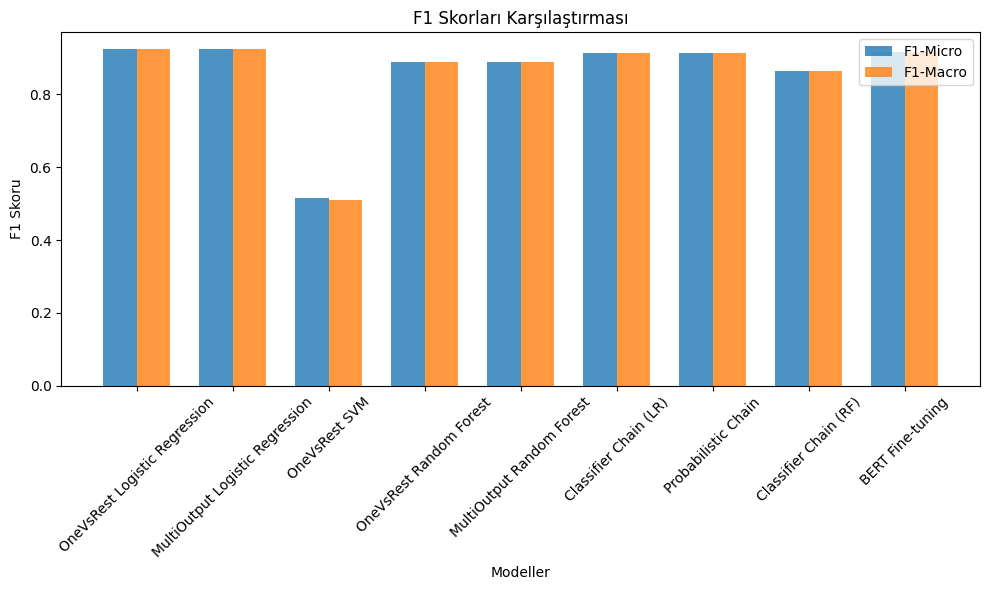

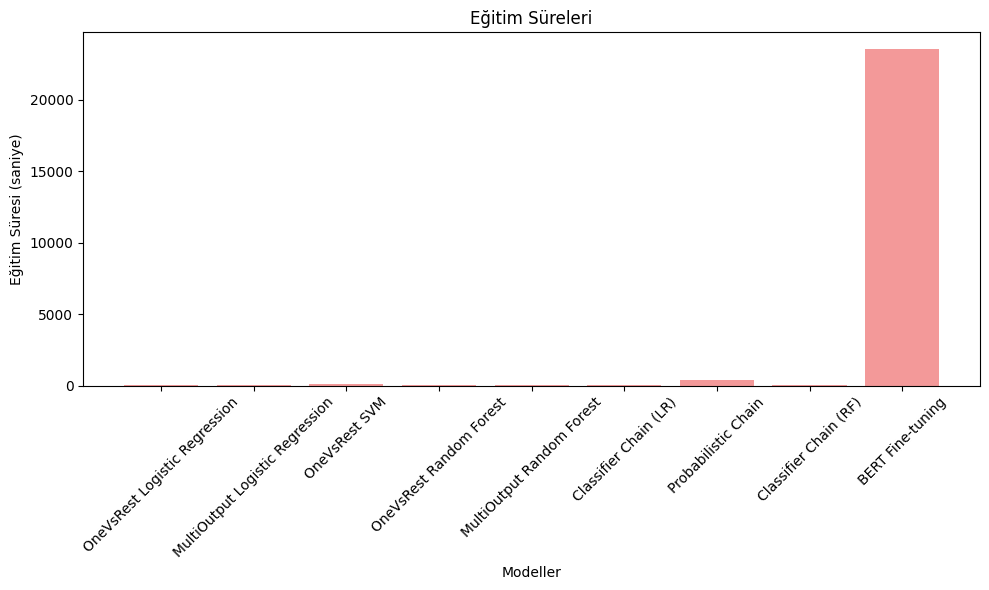

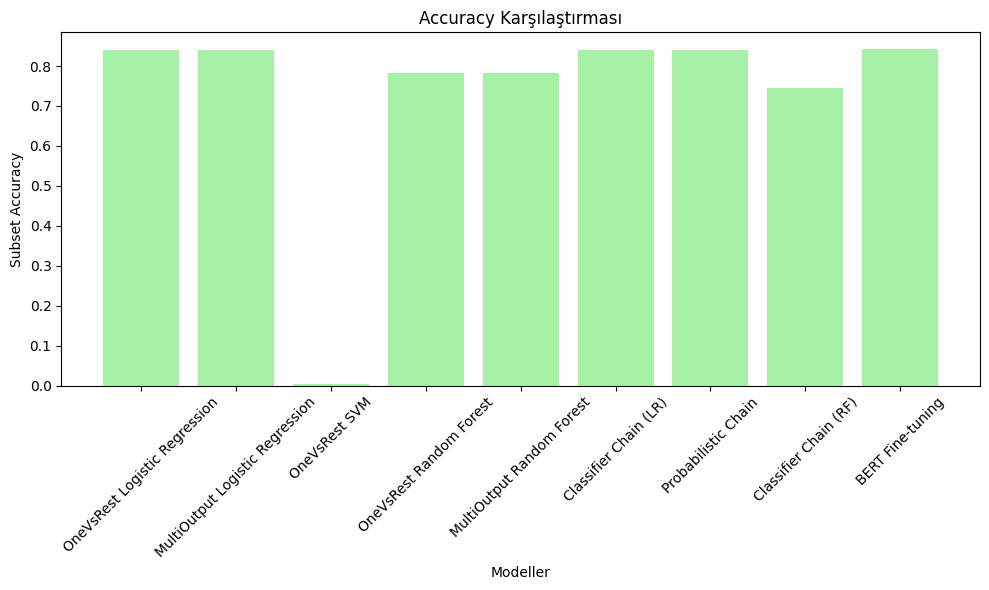

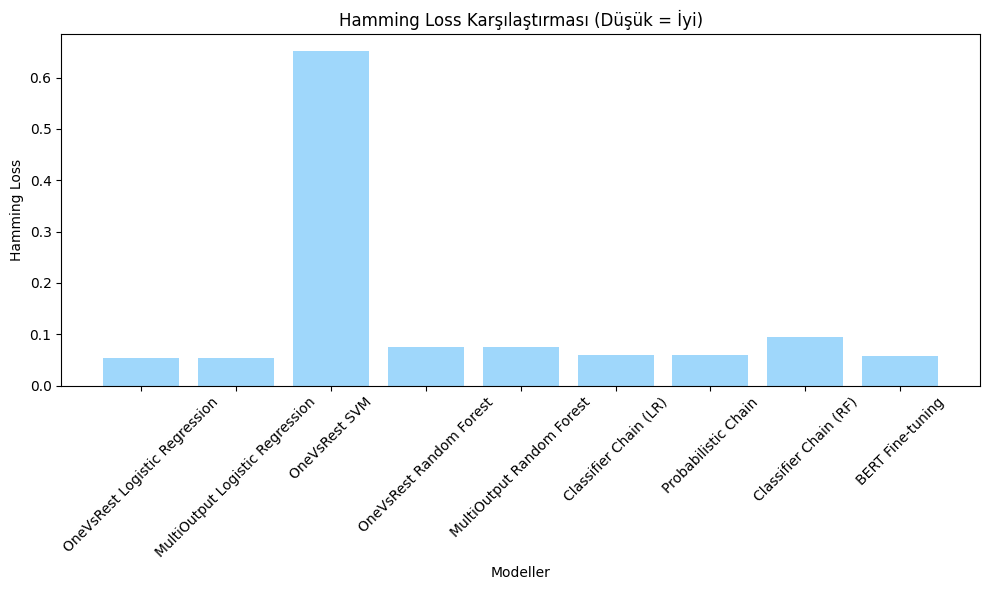

In [ ]:
# F1 skorları karşılaştırması
plt.figure(figsize=(10, 6))
models = comparison_df['model']
f1_micro_scores = comparison_df['f1_micro']
f1_macro_scores = comparison_df['f1_macro']

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, f1_micro_scores, width, label='F1-Micro', alpha=0.8)
plt.bar(x + width/2, f1_macro_scores, width, label='F1-Macro', alpha=0.8)
plt.xlabel('Modeller')
plt.ylabel('F1 Skoru')
plt.title('F1 Skorları Karşılaştırması')
plt.xticks(x, models, rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('f1_scores_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Eğitim süreleri
plt.figure(figsize=(10, 6))
plt.bar(models, comparison_df['train_time'], color='lightcoral', alpha=0.8)
plt.xlabel('Modeller')
plt.ylabel('Eğitim Süresi (saniye)')
plt.title('Eğitim Süreleri')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('training_times.png', dpi=300, bbox_inches='tight')
plt.show()

# Accuracy karşılaştırması
plt.figure(figsize=(10, 6))
plt.bar(models, comparison_df['accuracy'], color='lightgreen', alpha=0.8)
plt.xlabel('Modeller')
plt.ylabel('Subset Accuracy')
plt.title('Accuracy Karşılaştırması')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Hamming Loss karşılaştırması
plt.figure(figsize=(10, 6))
plt.bar(models, comparison_df['hamming_loss'], color='lightskyblue', alpha=0.8)
plt.xlabel('Modeller')
plt.ylabel('Hamming Loss')
plt.title('Hamming Loss Karşılaştırması (Düşük = İyi)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('hamming_loss.png', dpi=300, bbox_inches='tight')
plt.show()

### Modelleri ayrı ayrı kaydet

In [ ]:
import os
import json
from datetime import datetime

# Ana models klasörü
models_dir = 'saved_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Timestamp ile alt klasör
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
session_dir = os.path.join(models_dir, f'session_{timestamp}')
if not os.path.exists(session_dir):
    os.makedirs(session_dir)

print(f"Modeller şu klasöre kaydediliyor: {session_dir}")

# Başarıyla kaydedilen dosyalar listesi
saved_files = []
failed_files = []

# 1. TF-IDF Vectorizer'ı kaydet
try:
    with open(os.path.join(session_dir, 'tfidf_vectorizer.pkl'), 'wb') as f:
        pickle.dump(tfidf_vectorizer, f)
    saved_files.append('tfidf_vectorizer.pkl')
    print("✓ TF-IDF Vectorizer kaydedildi")
except Exception as e:
    failed_files.append(f'tfidf_vectorizer.pkl: {str(e)}')
    print(f"❌ TF-IDF Vectorizer kaydetme hatası: {e}")

# 2. OneVsRest Logistic Regression modelini kaydet
try:
    with open(os.path.join(session_dir, 'ovr_logistic_regression.pkl'), 'wb') as f:
        pickle.dump(lr_ovr_model, f)
    saved_files.append('ovr_logistic_regression.pkl')
    print("✓ OneVsRest Logistic Regression modeli kaydedildi")
except Exception as e:
    failed_files.append(f'ovr_logistic_regression.pkl: {str(e)}')
    print(f"❌ OneVsRest Logistic Regression kaydetme hatası: {e}")

# 2a. MultiOutput Logistic Regression modelini kaydet (karşılaştırma için)
try:
    with open(os.path.join(session_dir, 'multi_logistic_regression.pkl'), 'wb') as f:
        pickle.dump(lr_multi_model, f)
    saved_files.append('multi_logistic_regression.pkl')
    print("✓ MultiOutput Logistic Regression modeli kaydedildi")
except Exception as e:
    failed_files.append(f'multi_logistic_regression.pkl: {str(e)}')
    print(f"❌ MultiOutput Logistic Regression kaydetme hatası: {e}")

# 3. OneVsRest SVM modelini kaydet
try:
    with open(os.path.join(session_dir, 'ovr_svm.pkl'), 'wb') as f:
        pickle.dump(svm_ovr_model, f)
    saved_files.append('ovr_svm.pkl')
    print("✓ OneVsRest SVM modeli kaydedildi")
except Exception as e:
    failed_files.append(f'ovr_svm.pkl: {str(e)}')
    print(f"❌ OneVsRest SVM kaydetme hatası: {e}")

# 4. OneVsRest Random Forest modelini kaydet
try:
    with open(os.path.join(session_dir, 'ovr_random_forest.pkl'), 'wb') as f:
        pickle.dump(rf_ovr_model, f)
    saved_files.append('ovr_random_forest.pkl')
    print("✓ OneVsRest Random Forest modeli kaydedildi")
except Exception as e:
    failed_files.append(f'ovr_random_forest.pkl: {str(e)}')
    print(f"❌ OneVsRest Random Forest kaydetme hatası: {e}")

# 4a. MultiOutput Random Forest modelini kaydet (karşılaştırma için)
try:
    with open(os.path.join(session_dir, 'multi_random_forest.pkl'), 'wb') as f:
        pickle.dump(rf_multi_model, f)
    saved_files.append('multi_random_forest.pkl')
    print("✓ MultiOutput Random Forest modeli kaydedildi")
except Exception as e:
    failed_files.append(f'multi_random_forest.pkl: {str(e)}')
    print(f"❌ MultiOutput Random Forest kaydetme hatası: {e}")

# 4. Classifier Chain (LR) modelini kaydet
try:
    with open(os.path.join(session_dir, 'classifier_chain_lr.pkl'), 'wb') as f:
        pickle.dump(cc_lr_model, f)
    saved_files.append('classifier_chain_lr.pkl')
    print("✓ Classifier Chain (LR) modeli kaydedildi")
except Exception as e:
    failed_files.append(f'classifier_chain_lr.pkl: {str(e)}')
    print(f"❌ Classifier Chain (LR) kaydetme hatası: {e}")

# 5. Probabilistic Chain modelini kaydet
try:
    with open(os.path.join(session_dir, 'probabilistic_chain.pkl'), 'wb') as f:
        pickle.dump(pcc_model, f)
    saved_files.append('probabilistic_chain.pkl')
    print("✓ Probabilistic Chain modeli kaydedildi")
except Exception as e:
    failed_files.append(f'probabilistic_chain.pkl: {str(e)}')
    print(f"❌ Probabilistic Chain kaydetme hatası: {e}")

# 6. Classifier Chain (RF) modelini kaydet
try:
    with open(os.path.join(session_dir, 'classifier_chain_rf.pkl'), 'wb') as f:
        pickle.dump(cc_rf_model, f)
    saved_files.append('classifier_chain_rf.pkl')
    print("✓ Classifier Chain (RF) modeli kaydedildi")
except Exception as e:
    failed_files.append(f'classifier_chain_rf.pkl: {str(e)}')
    print(f"❌ Classifier Chain (RF) kaydetme hatası: {e}")

# 7. Label columns'ı ayrı dosya olarak kaydet
try:
    with open(os.path.join(session_dir, 'label_columns.pkl'), 'wb') as f:
        pickle.dump(list(label_columns), f)
    saved_files.append('label_columns.pkl')
    print("✓ Label columns kaydedildi")
except Exception as e:
    failed_files.append(f'label_columns.pkl: {str(e)}')
    print(f"❌ Label columns kaydetme hatası: {e}")

# 8. Performance results'ı ayrı dosya olarak kaydet
try:
    # Performance results'ı temizle
    clean_performance = []
    for result in performance_results:
        clean_result = {}
        for key, value in result.items():
            if not callable(value):
                clean_result[key] = value
        clean_performance.append(clean_result)
    
    with open(os.path.join(session_dir, 'performance_results.pkl'), 'wb') as f:
        pickle.dump(clean_performance, f)
    saved_files.append('performance_results.pkl')
    print("✓ Performance results kaydedildi")
except Exception as e:
    failed_files.append(f'performance_results.pkl: {str(e)}')
    print(f"❌ Performance results kaydetme hatası: {e}")

# 9. Correlation matrix'i ayrı dosya olarak kaydet
try:
    with open(os.path.join(session_dir, 'correlation_matrix.pkl'), 'wb') as f:
        pickle.dump(correlation_matrix, f)
    saved_files.append('correlation_matrix.pkl')
    print("✓ Correlation matrix kaydedildi")
except Exception as e:
    failed_files.append(f'correlation_matrix.pkl: {str(e)}')
    print(f"❌ Correlation matrix kaydetme hatası: {e}")

# 10. High correlation pairs'i ayrı dosya olarak kaydet
try:
    with open(os.path.join(session_dir, 'high_corr_pairs.pkl'), 'wb') as f:
        pickle.dump(high_corr_pairs, f)
    saved_files.append('high_corr_pairs.pkl')
    print("✓ High correlation pairs kaydedildi")
except Exception as e:
    failed_files.append(f'high_corr_pairs.pkl: {str(e)}')
    print(f"❌ High correlation pairs kaydetme hatası: {e}")

# 11. Model parametrelerini JSON olarak kaydet
try:
    model_params = {
        'max_features': max_features,
        'ngram_range': ngram_range,
        'min_df': min_df,
        'max_df': max_df,
        'test_size': test_size,
        'random_state': random_state,
        'preprocessing_info': {
            'description': 'Metin ön işleme: küçük harf + özel karakter temizleme + boşluk normalizasyonu',
            'pattern': r'[^a-zA-Z0-9\s]',
            'replacement': ' '
        }
    }
    
    with open(os.path.join(session_dir, 'model_parameters.json'), 'w', encoding='utf-8') as f:
        json.dump(model_params, f, indent=2, ensure_ascii=False)
    saved_files.append('model_parameters.json')
    print("✓ Model parametreleri JSON olarak kaydedildi")
except Exception as e:
    failed_files.append(f'model_parameters.json: {str(e)}')
    print(f"❌ Model parametreleri kaydetme hatası: {e}")

# 12. BERT Fine-tuning modelini kaydet (eğer varsa)
if BERT_AVAILABLE and bert_pred is not None:
    try:
        with open(os.path.join(session_dir, 'bert_finetuned_model.pkl'), 'wb') as f:
            pickle.dump(bert_classifier, f)
        saved_files.append('bert_finetuned_model.pkl')
        print("✓ BERT Fine-tuned modeli kaydedildi")
    except Exception as e:
        failed_files.append(f'bert_finetuned_model.pkl: {str(e)}')
        print(f"❌ BERT Fine-tuned modeli kaydetme hatası: {e}")
    
    try:
        with open(os.path.join(session_dir, 'bert_finetuned_tokenizer.pkl'), 'wb') as f:
            pickle.dump(bert_tokenizer, f)
        saved_files.append('bert_finetuned_tokenizer.pkl')
        print("✓ BERT Fine-tuned tokenizer kaydedildi")
    except Exception as e:
        failed_files.append(f'bert_finetuned_tokenizer.pkl: {str(e)}')
        print(f"❌ BERT Fine-tuned tokenizer kaydetme hatası: {e}")
    
    # BERT Fine-tuner'ı da kaydet
    try:
        with open(os.path.join(session_dir, 'bert_fine_tuner.pkl'), 'wb') as f:
            pickle.dump(bert_fine_tuner, f)
        saved_files.append('bert_fine_tuner.pkl')
        print("✓ BERT Fine-tuner kaydedildi")
    except Exception as e:
        failed_files.append(f'bert_fine_tuner.pkl: {str(e)}')
        print(f"❌ BERT Fine-tuner kaydetme hatası: {e}")

Modeller şu klasöre kaydediliyor: saved_models\session_20250826_070030
✓ TF-IDF Vectorizer kaydedildi
✓ OneVsRest Logistic Regression modeli kaydedildi
✓ MultiOutput Logistic Regression modeli kaydedildi
✓ OneVsRest SVM modeli kaydedildi
✓ OneVsRest Random Forest modeli kaydedildi
✓ MultiOutput Random Forest modeli kaydedildi
✓ Classifier Chain (LR) modeli kaydedildi
✓ Probabilistic Chain modeli kaydedildi
✓ Classifier Chain (RF) modeli kaydedildi
✓ Label columns kaydedildi
✓ Performance results kaydedildi
✓ Correlation matrix kaydedildi
✓ High correlation pairs kaydedildi
✓ Model parametreleri JSON olarak kaydedildi
✓ BERT Fine-tuned modeli kaydedildi
✓ BERT Fine-tuned tokenizer kaydedildi
✓ BERT Fine-tuner kaydedildi


#### Kayıt raporunu oluştur

In [ ]:
save_report = {
    'timestamp': timestamp,
    'session_directory': session_dir,
    'total_files': len(saved_files) + len(failed_files),
    'successful_saves': len(saved_files),
    'failed_saves': len(failed_files),
    'saved_files': saved_files,
    'failed_files': failed_files
}

# Raporu JSON olarak kaydet
try:
    with open(os.path.join(session_dir, 'save_report.json'), 'w', encoding='utf-8') as f:
        json.dump(save_report, f, indent=2, ensure_ascii=False)
    print("✓ Kayıt raporu oluşturuldu")
except Exception as e:
    print(f"❌ Kayıt raporu oluşturma hatası: {e}")

# Özet rapor
print(f"\n=== KAYIT ÖZETİ ===")
print(f"📁 Kayıt klasörü: {session_dir}")
print(f"✅ Başarılı: {len(saved_files)} dosya")
print(f"❌ Başarısız: {len(failed_files)} dosya")

if saved_files:
    print(f"\n📋 Kaydedilen dosyalar:")
    for file in saved_files:
        print(f"  ✓ {file}")

if failed_files:
    print(f"\n⚠️ Kaydedemediği dosyalar:")
    for file in failed_files:
        print(f"  ❌ {file}")

print(f"\n📊 Toplam dosya boyutu:")
total_size = 0
for file in saved_files:
    try:
        file_path = os.path.join(session_dir, file)
        if os.path.exists(file_path):
            size = os.path.getsize(file_path)
            total_size += size
            print(f"  {file}: {size/1024/1024:.2f} MB")
    except:
        continue

print(f"📦 Toplam: {total_size/1024/1024:.2f} MB")



✓ Kayıt raporu oluşturuldu

=== KAYIT ÖZETİ ===
📁 Kayıt klasörü: saved_models\session_20250826_070030
✅ Başarılı: 17 dosya
❌ Başarısız: 0 dosya

📋 Kaydedilen dosyalar:
  ✓ tfidf_vectorizer.pkl
  ✓ ovr_logistic_regression.pkl
  ✓ multi_logistic_regression.pkl
  ✓ ovr_svm.pkl
  ✓ ovr_random_forest.pkl
  ✓ multi_random_forest.pkl
  ✓ classifier_chain_lr.pkl
  ✓ probabilistic_chain.pkl
  ✓ classifier_chain_rf.pkl
  ✓ label_columns.pkl
  ✓ performance_results.pkl
  ✓ correlation_matrix.pkl
  ✓ high_corr_pairs.pkl
  ✓ model_parameters.json
  ✓ bert_finetuned_model.pkl
  ✓ bert_finetuned_tokenizer.pkl
  ✓ bert_fine_tuner.pkl

📊 Toplam dosya boyutu:
  tfidf_vectorizer.pkl: 1.91 MB
  ovr_logistic_regression.pkl: 1.53 MB
  multi_logistic_regression.pkl: 1.53 MB
  ovr_svm.pkl: 4.42 MB
  ovr_random_forest.pkl: 40.02 MB
  multi_random_forest.pkl: 40.02 MB
  classifier_chain_lr.pkl: 1.53 MB
  probabilistic_chain.pkl: 1.53 MB
  classifier_chain_rf.pkl: 10.18 MB
  label_columns.pkl: 0.00 MB
  performa